In [2]:
# Importing useful libraries
from __future__ import print_function
import sys
import time
import numpy as np
import scipy
import scipy.sparse
import scipy.ndimage
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib as mpl
import matplotlib.pyplot as plt
import skimage.data, skimage.io

In [3]:
# Timer
class Timer(object):
    def __init__(self, name=None):
        self.name = name

    def __enter__(self):
        self.tstart = time.time()

    def __exit__(self, type, value, traceback):
        if self.name:
            print('[%s] ' % self.name)
        print('Elapsed: %.2f seconds' % (time.time() - self.tstart))

# Debugging
def mydebug(*objs):
    print("**debug: ", *objs, file=sys.stderr)
    
# A 3D plotting function, for showing the kernel we use
def plotkernel(mykernel, ksize):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    X = np.arange(0, ksize, 1)
    Y = np.arange(0, ksize, 1)
    X, Y = np.meshgrid(X, Y)
    surf = ax.plot_surface(X, Y, mykernel, rstride=1, 
                           cstride=1, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    ax.set_zlim(0, np.max(mykernel))                           
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()

In [24]:
def makespdiag(pattern,N):
    """
    This makes a diagonal sparse matrix,similar to a convolution kernel operator

    e.g: 
        makediag([1,2,1],5).todense()

    matrix([[ 2.,  1.,  0.,  0.,  0.],
            [ 1.,  2.,  1.,  0.,  0.],
            [ 0.,  1.,  2.,  1.,  0.],
            [ 0.,  0.,  1.,  2.,  1.],
            [ 0.,  0.,  0.,  1.,  2.]])
    """
    # strangely, all diags may have the same length
    diags = [] # empty list
    for i in pattern :
        diags.append(np.zeros(N) + i)
    n = len(pattern)
    positions = np.arange(-int(n/2),int(n/2)+1)
    ## print positions
    mat = scipy.sparse.dia_matrix((diags, positions), shape=(N, N))
    return mat

In [5]:
def make_kernel_2D(PSF, dims,debug=False):
    """
        PSF is the 2D kernel
        dims are is the side size of the image in order (r,c) 
    """
    d = len(PSF) ## assmuming square PSF (but not necessarily square image)
    print("kernel dimensions=", dims)
    N = dims[0]*dims[1]
    if debug:
        mydebug("Making kernel with %d diagonals all %d long\n" % (d*d, N))
    ## pre-fill a 2D matrix for the diagonals
    diags = np.zeros((d*d, N))
    offsets = np.zeros(d*d)
    heads = np.zeros(d*d) ## for this a list is OK
    i = 0
    for y in range(len(PSF)):
        for x in range(len(PSF[y])):
            diags[i,:] += PSF[y,x]
            heads[i] = PSF[y,x]
            xdist = d/2 - x 
            ydist = d/2 - y ## y direction pointing down
            offsets[i] = (ydist*dims[1]+xdist)
            i+=1
    ## for debugging
    if debug:
        mydebug("Offsets: ", offsets)
        mydebug("Diagonal heads", heads)
        mydebug("Diagonals", diags) # only useful for small test matrices
    ## create linear operator
    H = scipy.sparse.dia_matrix((diags,offsets),shape=(N,N))
    return(H)

In [6]:
def make_blur_matrix(img, kernel_size=11,debug=True):
    n = kernel_size
    k2 = np.zeros(shape=(n,n))
    k2[int(n/2),int(n/2)] = 1
    sigma = kernel_size/5.0 ## 2.5 sigma
    testk = scipy.ndimage.gaussian_filter(k2,sigma)  ## already normalized
    if (debug):
        plotkernel(testk,n)  
    blurmat = make_kernel_2D(testk,img.shape)
    return(blurmat)

In [7]:
from scipy.sparse import linalg
def deblur_img(blurred_image, blur_matrix, method='spsolve'):
    '''
        Given the blur matrix, this deblurs the input image
    '''
    if (method=='spsolve'):
        deblur = linalg.spsolve(blur_matrix.tocsr(),blurred_image.reshape(-1))
    elif (method=='dense'):
        deblur = linalg.solve(blur_matrix.todense(),blurred_image.reshape(-1))
    else:
        deblur = linalg.cg(blur_matrix,blurred_image.reshape(-1))[0]
    return(deblur.reshape(blurred_image.shape)) 

In [8]:
def solve_tykhonov_sparse(y, Degrad, Gamma):
    """
    Tykhonov regularization of an observed signal, given a linear degradation matrix
    and a Gamma regularization matrix. 
    Formula is
    
    x* = (H'H + G'G)^{-1} H'y
    
    With y the observed signal, H the degradation matrix, G the regularization matrix.

    This function is better than dense_tykhonov in the sense that it does
    not attempt to invert the matrix H'H + G'G.
    """
    H1 = Degrad.T.dot(Degrad) # may not be sparse any longer in the general case
    H2 = H1 + Gamma.T.dot(Gamma) # same
    b2 = Degrad.T.dot(y.reshape(-1))
    result = scipy.sparse.linalg.cg(H2,b2)
    return result[0].reshape(y.shape)

In [9]:
def deblur_tikh_sparse(blurred,PSF_matrix,mylambda,method='Id'):
    t1=time.time()
    N = np.prod(blurred.shape)            
    if (method=='Grad'):
        G=makespdiag([0,-1,1],N).toarray()
    elif (method=='Lap'):
        G=make_kernel_2D(np.array([[-1,-1,-1],
                                          [-1,8,-1],
                                          [-1,-1,-1]]),blurred.shape)
    else:
        G=makespdiag([1],N)  ## identity

    elapsed1= time.time()-t1
    t2=time.time()   
    deblurred = solve_tykhonov_sparse(blurred,PSF_matrix,mylambda*G)
    elapsed2=time.time()-t2
    print("Time: %2f s constructing the matrix ; %2f s solving it\n" % (elapsed1,elapsed2))
    return deblurred

In [10]:
def blur_noise_image(given_image, blur_matrix,noise_scale=0.002):
    '''
        This code applies a linear operator in the form of a matrix, similar to
        refblur = scipy.ndimage.convolve(img, testk, mode='constant', cval=0.0)    
    '''
    ## apply blur + noise
    # reshaped to vector
    imgshape=given_image.shape
    N = np.prod(imgshape)
    blurredvect = blur_matrix.dot(given_image.reshape(-1)) + np.random.normal(scale=noise_scale,size=N)
    blurredimg = blurredvect.reshape(imgshape)
    return blurredimg

In [11]:
try:
    import mkl
    have_mkl = True
    backend = 'anaconda+mkl'
    print("Running with MKL Acceleration with %d threads" % mkl.get_max_threads())
except ImportError:
    have_mkl = False
    backend = 'anaconda'
    print("Running with normal backends")

Running with MKL Acceleration with 6 threads


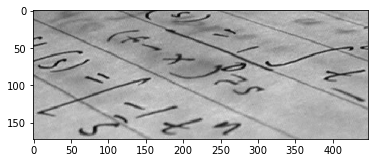

In [12]:
# this image is a simple image of text
imgbig = skimage.data.text()
initplot=plt.imshow(imgbig,cmap='gray')

C:\Users\andru\AppData\Local\Temp\ipykernel_17308\59411320.py:21: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


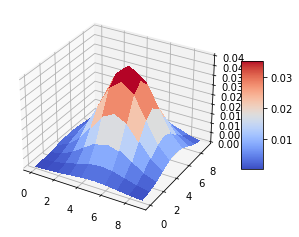

kernel dimensions= (70, 70)


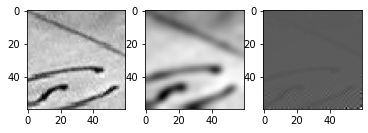

In [18]:
# We reduce the size
tinyimg1 = imgbig[20:80,20:80]
b = 10 ## blur size
# Pad the image
hb = int(b/2)
tinyimg = np.pad(tinyimg1,hb,'reflect')
tinyblurmat = make_blur_matrix(tinyimg, b,debug=True)
# that is a *minscule* amount of noise
tinyblurredimg = blur_noise_image(tinyimg,tinyblurmat,noise_scale=5e-6)
tinydeblurred = deblur_img(tinyblurredimg, tinyblurmat)
fig,(ax1,ax2,ax3) = plt.subplots(1, 3)
ax1.imshow(tinyimg[hb:-hb,hb:-hb],cmap="gray")
ax2.imshow(tinyblurredimg[hb:-hb,hb:-hb],cmap="gray")
ax3.imshow(tinydeblurred[hb:-hb,hb:-hb],cmap="gray")

kernel dimensions= (182, 260)


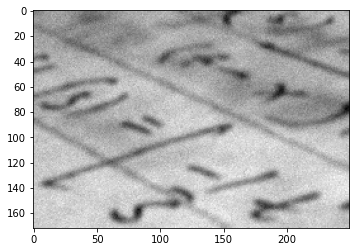

In [21]:
img1 = imgbig[0:250,0:250]
## we use the same blur size as above
img = np.pad(img1,hb,'reflect')
N = np.prod(img.shape)    
blurmat = make_blur_matrix(img, b,debug=False) 
blurredimg = blur_noise_image(img,blurmat,noise_scale=5.0)    
imgplot=plt.imshow(blurredimg[hb:-hb,hb:-hb],cmap="gray")

kernel dimensions= (182, 260)
Time: 0.007994 s constructing the matrix ; 8.961591 s solving it

[Deblurring with Tikhonov] 
Elapsed: 8.97 seconds


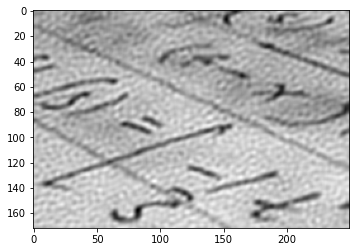

In [26]:
## tikhonov
with Timer("Deblurring with Tikhonov"):
    deblur_tikh = deblur_tikh_sparse(blurredimg, blurmat, 0.025, method='Lap')

plt.imshow(deblur_tikh[hb:-hb,hb:-hb],cmap="gray")